In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,LSTM , Dense, Dropout , BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Constant
from transformers import BertTokenizer, TFAutoModel
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

C:\Users\sario\anaconda3\envs\rihal_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
# !pip install pandas numpy matplotlib seaborn plotly wordcloud nltk textblob scikit-learn tensorflow transformers gensim torch

In [2]:
# # Load the dataset
train_file_path = 'C:/Users/sario/Downloads/N24News/news/nytimes_train.json'
test_file_path = 'C:/Users/sario/Downloads/N24News/news/nytimes_test.json'
train_df = pd.read_json(train_file_path, orient = 'records')
test_df = pd.read_json(test_file_path, orient = 'records')

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48988 entries, 0 to 48987
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   section      48988 non-null  object
 1   headline     48988 non-null  object
 2   article_url  48988 non-null  object
 3   article      48988 non-null  object
 4   abstract     48988 non-null  object
 5   article_id   48988 non-null  object
 6   image        48988 non-null  object
 7   caption      48988 non-null  object
 8   image_id     48988 non-null  object
dtypes: object(9)
memory usage: 3.4+ MB


In [22]:
train_df.isna().sum()

section        0
headline       0
article_url    0
article        0
abstract       0
article_id     0
image          0
caption        0
image_id       0
dtype: int64

In [23]:
train_df['section'].value_counts()

section
Opinion            2437
Art & Design       2431
Television         2419
Music              2416
Travel             2413
Real Estate        2413
Books              2412
Theater            2409
Health             2409
Sports             2407
Science            2387
Fashion & Style    2385
Food               2385
Movies             2384
Technology         2376
Dance              2365
Media              2363
Style              2147
Automobiles        1456
Economy            1398
Your Money         1020
Global Business     955
Education           672
Well                529
Name: count, dtype: int64

In [3]:
train_df['article_length'] = train_df['article'].str.len()
train_df['article_length']

0        6566
1        2932
2        6408
3        7174
4         566
         ... 
48983     272
48984    1070
48985    1011
48986    5058
48987    1675
Name: article_length, Length: 48988, dtype: int64

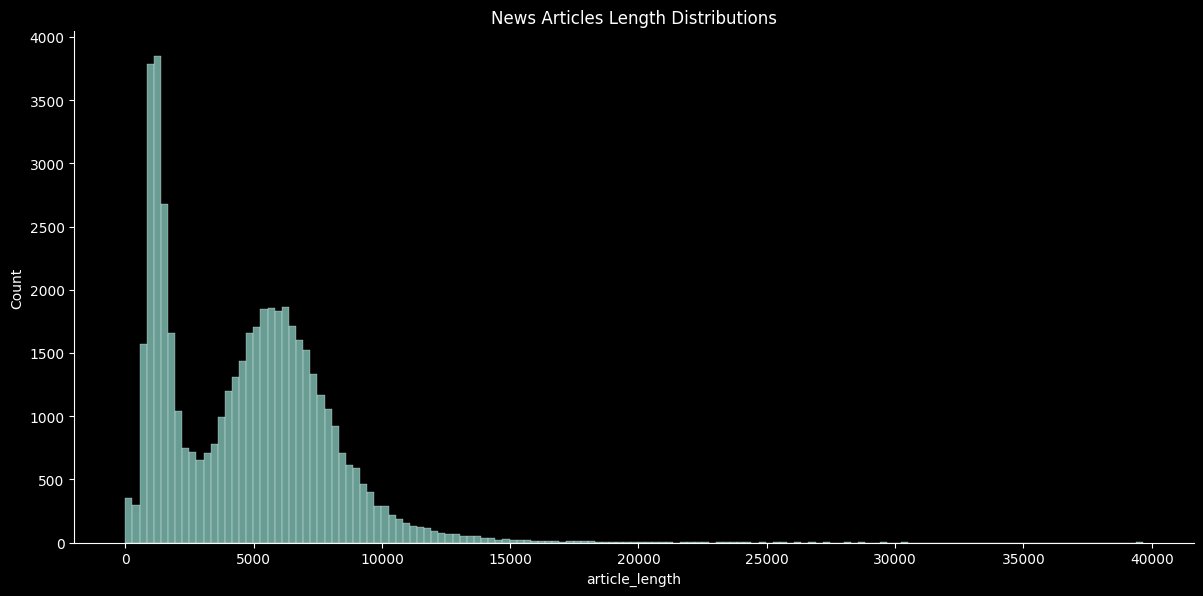

In [41]:
plot = sns.displot(train_df['article_length']).set( 
    title="News Articles Length Distributions")
plot.fig.set_figwidth(14)
plot.fig.set_figheight(6)

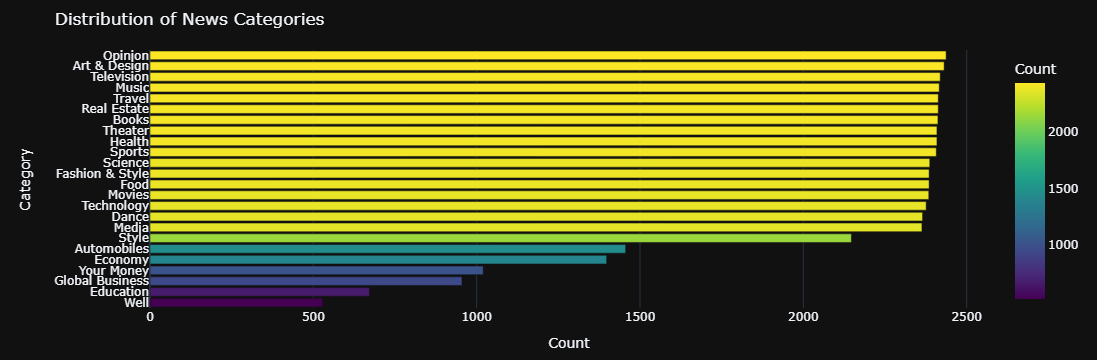

In [42]:
category_counts = train_df['section'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort the DataFrame by count in ascending order
category_counts = category_counts.sort_values(by='Count', ascending=True)

# Create an interactive bar plot with dark theme
fig = px.bar(
    category_counts,
    x='Count',
    y='Category',
    orientation='h',
    title='Distribution of News Categories',
    labels={'Count': 'Number of News'},
    color='Count',
    color_continuous_scale='viridis',
)

# Customize the layout for dark theme and adjust y-axis scale
fig.update_layout(
    template='plotly_dark',
    xaxis_title='Count',
    yaxis_title='Category',
    coloraxis_colorbar=dict(title='Count'),
)

# Increase the scale of the y-axis
fig.update_yaxes(categoryorder='total ascending', tickmode='linear', tick0=0, dtick=1)

# Adjust figure size and margins
fig.update_layout(height=800, margin=dict(l=150, r=20, t=50, b=50))

# Show the plot
fig.show()

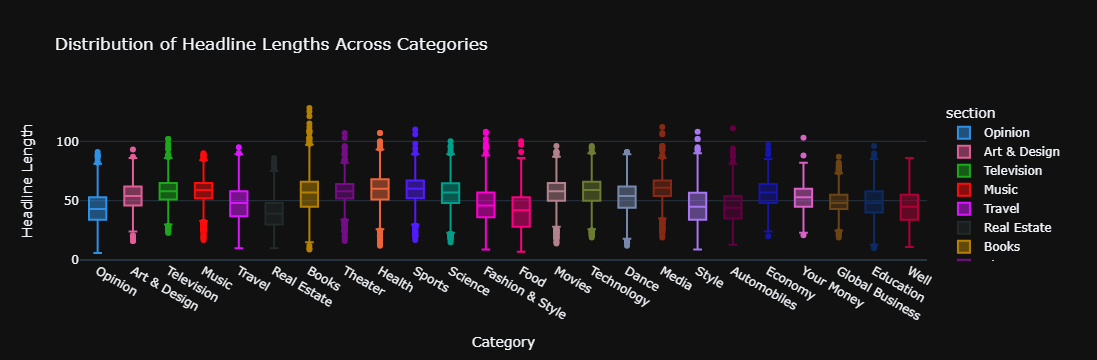

In [43]:
# Assuming 'df' is your DataFrame
train_df['headline_length'] = train_df['headline'].apply(len)

# Create an interactive box plot with dark theme
fig = px.box(
    train_df,
    x='section',
    y='headline_length',
    color='section',
    category_orders={'section': train_df['section'].value_counts().index},
    title='Distribution of Headline Lengths Across Categories',
    labels={'headline_length': 'Headline Length'},
    color_discrete_sequence=px.colors.qualitative.Dark24,
)

# Customize the layout for dark theme
fig.update_layout(
    template='plotly_dark',
    xaxis_title='Category',
    yaxis_title='Headline Length',
)

# Show the plot
fig.show()

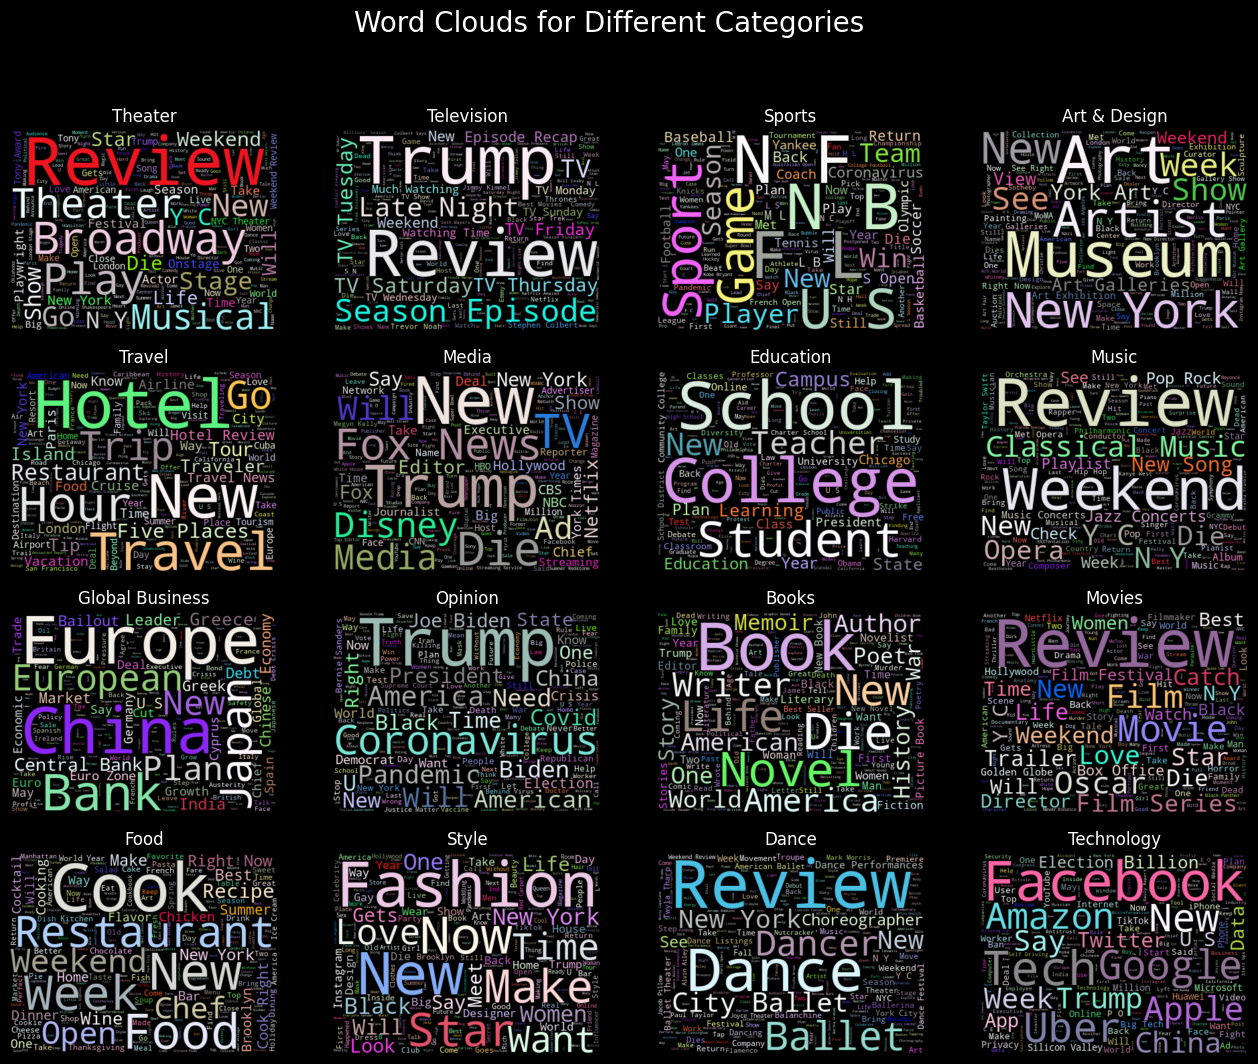

In [44]:
# Function to generate random color
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * random.random())
    s = int(100.0 * random.random())
    l = int(50.0 * random.random()) + 50
    return "hsl({}, {}%, {}%)".format(h, s, l)

# Set dark background
plt.style.use('dark_background')

# Create an interactive word cloud for each category with dark theme
fig, axes = plt.subplots(4, 4, figsize=(16, 12), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
for ax, category in zip(axes.flatten(), train_df['section'].unique()):
    wordcloud = WordCloud(width=400, height=300, random_state=42, max_font_size=100, background_color='black',
                          color_func=random_color_func, stopwords=STOPWORDS).generate(' '.join(train_df[train_df['section']==category]['headline']))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(category, color='white')  # Set title color to white for visibility
plt.suptitle('Word Clouds for Different Categories', fontsize=20, color='white')  # Set suptitle color to white
plt.show()

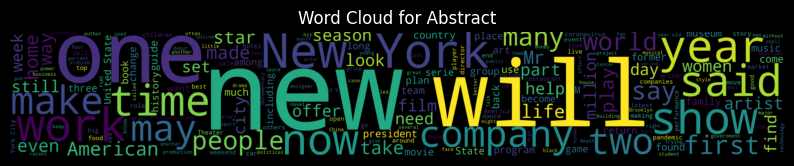

In [45]:
text = ' '.join(train_df['abstract'].dropna())

# Create an interactive word cloud
wordcloud = WordCloud(width=5000, height=800, background_color='black', colormap='viridis').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 19))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Abstract')
plt.show()

In [46]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6124 entries, 0 to 6123
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   section      6124 non-null   object
 1   headline     6124 non-null   object
 2   article_url  6124 non-null   object
 3   article      6124 non-null   object
 4   abstract     6124 non-null   object
 5   article_id   6124 non-null   object
 6   image        6124 non-null   object
 7   caption      6124 non-null   object
 8   image_id     6124 non-null   object
dtypes: object(9)
memory usage: 430.7+ KB


In [47]:
test_df.isna().sum()

section        0
headline       0
article_url    0
article        0
abstract       0
article_id     0
image          0
caption        0
image_id       0
dtype: int64

In [48]:
test_df['section'].value_counts()

section
Media              326
Technology         325
Dance              318
Art & Design       313
Theater            311
Fashion & Style    307
Health             307
Science            306
Books              305
Real Estate        299
Movies             292
Food               290
Travel             287
Music              286
Opinion            284
Television         281
Sports             280
Style              263
Economy            183
Automobiles        173
Your Money         134
Global Business    100
Well                80
Education           74
Name: count, dtype: int64

In [4]:
test_df['article_length'] = test_df['article'].str.len()
test_df['article_length']

0       5965
1       5241
2        935
3       1536
4       8177
        ... 
6119    8113
6120    6328
6121    5173
6122    6912
6123    3552
Name: article_length, Length: 6124, dtype: int64

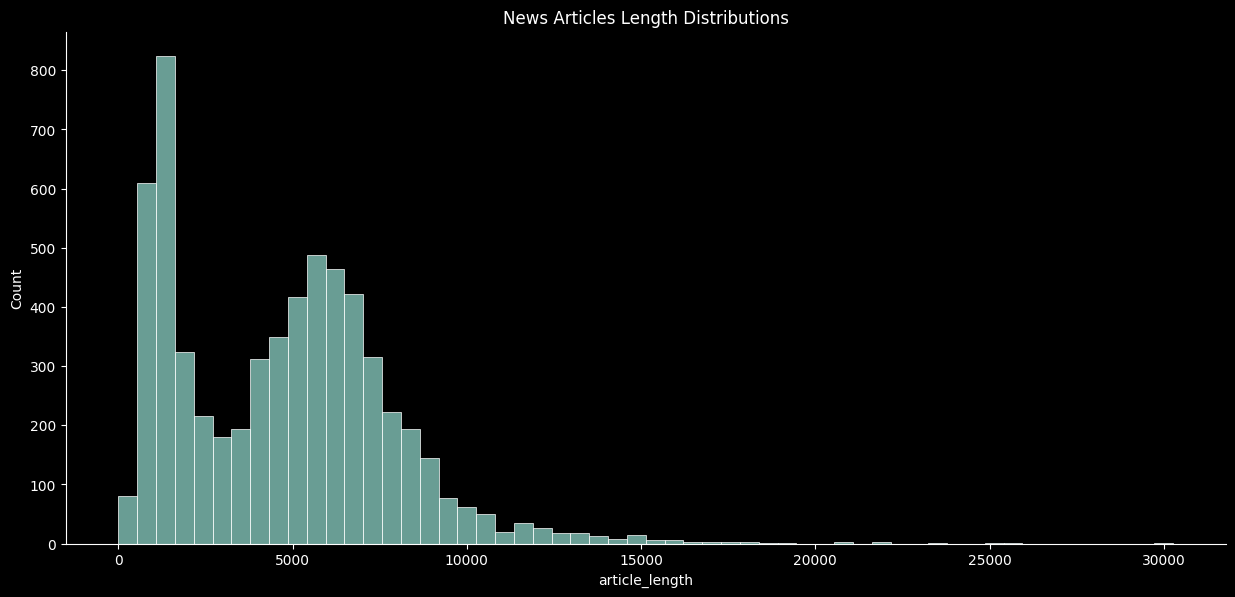

In [50]:
plot = sns.displot(test_df['article_length']).set( 
    title="News Articles Length Distributions")
plot.fig.set_figwidth(14)
plot.fig.set_figheight(6)

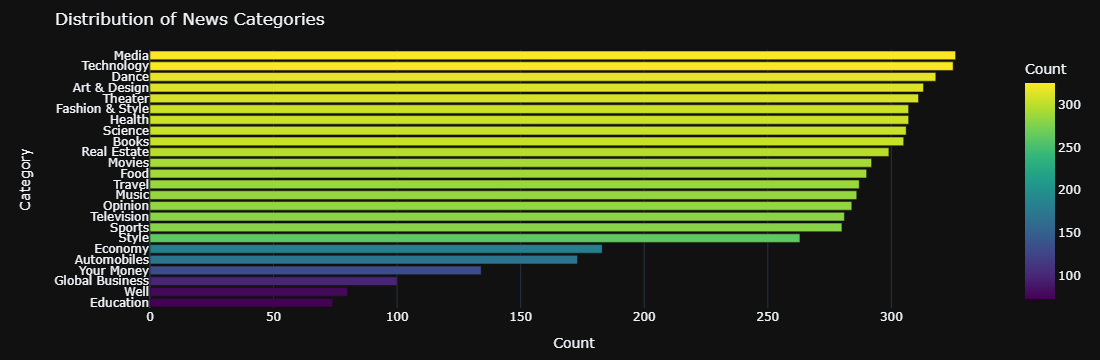

In [51]:
category_counts = test_df['section'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Sort the DataFrame by count in ascending order
category_counts = category_counts.sort_values(by='Count', ascending=True)

# Create an interactive bar plot with dark theme
fig = px.bar(
    category_counts,
    x='Count',
    y='Category',
    orientation='h',
    title='Distribution of News Categories',
    labels={'Count': 'Number of News'},
    color='Count',
    color_continuous_scale='viridis',
)

# Customize the layout for dark theme and adjust y-axis scale
fig.update_layout(
    template='plotly_dark',
    xaxis_title='Count',
    yaxis_title='Category',
    coloraxis_colorbar=dict(title='Count'),
)

# Increase the scale of the y-axis
fig.update_yaxes(categoryorder='total ascending', tickmode='linear', tick0=0, dtick=1)

# Adjust figure size and margins
fig.update_layout(height=800, margin=dict(l=150, r=20, t=50, b=50))

# Show the plot
fig.show()

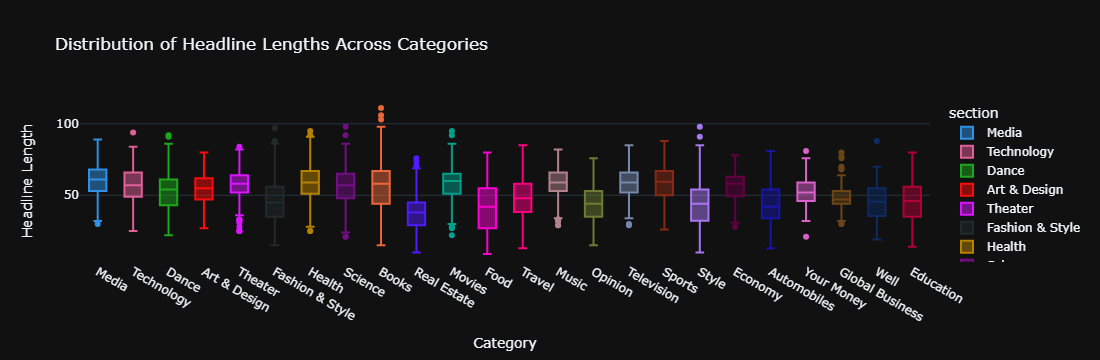

In [52]:
# Assuming 'df' is your DataFrame
test_df['headline_length'] = test_df['headline'].apply(len)

# Create an interactive box plot with dark theme
fig = px.box(
    test_df,
    x='section',
    y='headline_length',
    color='section',
    category_orders={'section': test_df['section'].value_counts().index},
    title='Distribution of Headline Lengths Across Categories',
    labels={'headline_length': 'Headline Length'},
    color_discrete_sequence=px.colors.qualitative.Dark24,
)

# Customize the layout for dark theme
fig.update_layout(
    template='plotly_dark',
    xaxis_title='Category',
    yaxis_title='Headline Length',
)

# Show the plot
fig.show()

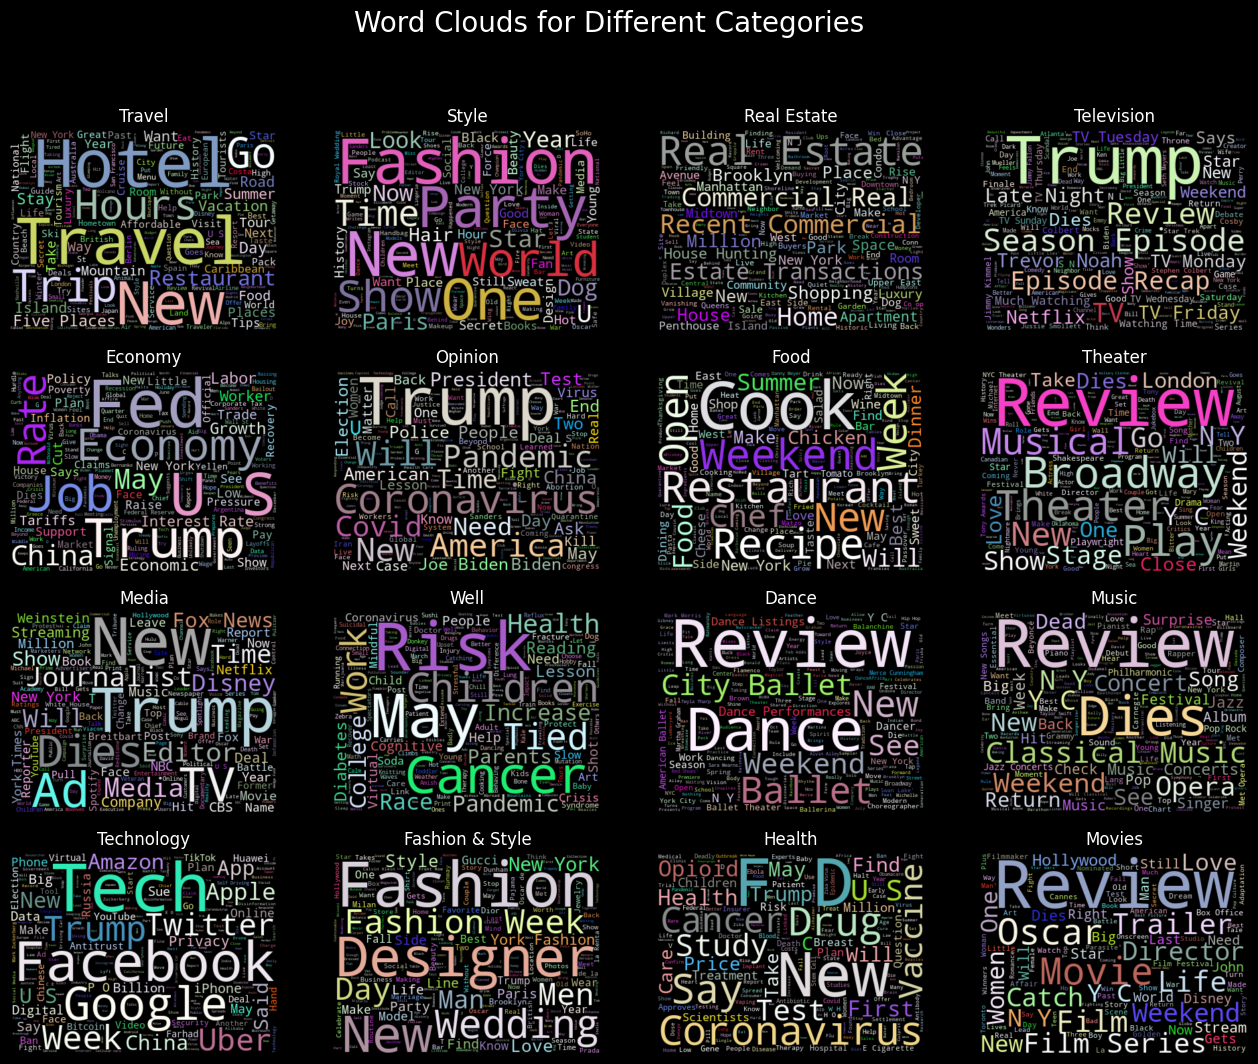

In [53]:
# Function to generate random color
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * random.random())
    s = int(100.0 * random.random())
    l = int(50.0 * random.random()) + 50
    return "hsl({}, {}%, {}%)".format(h, s, l)

# Set dark background
plt.style.use('dark_background')

# Create an interactive word cloud for each category with dark theme
fig, axes = plt.subplots(4, 4, figsize=(16, 12), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
for ax, category in zip(axes.flatten(), test_df['section'].unique()):
    wordcloud = WordCloud(width=400, height=300, random_state=42, max_font_size=100, background_color='black',
                          color_func=random_color_func, stopwords=STOPWORDS).generate(' '.join(test_df[test_df['section']==category]['headline']))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(category, color='white')  # Set title color to white for visibility
plt.suptitle('Word Clouds for Different Categories', fontsize=20, color='white')  # Set suptitle color to white
plt.show()

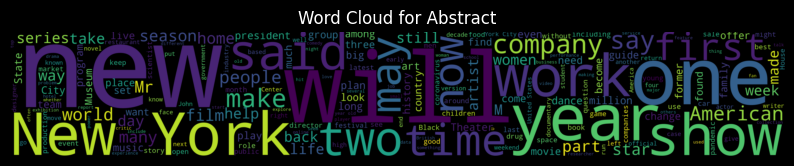

In [54]:
text = ' '.join(test_df['abstract'].dropna())

# Create an interactive word cloud
wordcloud = WordCloud(width=5000, height=800, background_color='black', colormap='viridis').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 19))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Abstract')
plt.show()

In [3]:
def process_text(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    
    
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    
    text = " ".join(filtered_sentence)
    return text

In [4]:
train_df['article_parsed'] = train_df['article'].apply(process_text)
train_df.head()

section                                           headline  \
0       Theater  Before 'Moonlight' and 'The Walking Dead,' a F...   
1    Television  What's on TV Wednesday: 'Crip Camp' and 'Dark ...   
2        Sports  Rays Stick to Their Plan and Reach a 2nd World...   
3  Art & Design    For Robert Rauschenberg, No Artist Is an Island   
4       Theater  Jimmy Buffett's 'Margaritaville' Musical Sets ...   

                                         article_url  \
0  https://www.nytimes.com/2017/02/21/theater/dan...   
1  https://www.nytimes.com/2020/03/25/arts/televi...   
2  https://www.nytimes.com/2020/10/17/sports/base...   
3  https://www.nytimes.com/2017/05/11/arts/design...   
4  https://www.nytimes.com/2017/06/05/theater/jim...   

                                             article  \
0  Danai Gurira and Andre Holland in a theater at...   
1  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2  The Tampa Bay Rays told Charlie Morton it woul...   
3  We tend to think of artists as natural loners,...   
4  Jimmy Buffett's tropical paradise will land in...   

                                            abstract  \
0  André Holland first saw Danai Gurira at New Yo...   
1  The documentary "Crip Camp: A Disability Revol...   
2  Guided by the club's strict principles, Manage...   
3  A writer travels from Brooklyn to Lafayette, L...   
4  "Escape to Margaritaville," which features new...   

                             article_id  \
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa   
1  67b1b62f-43ea-59d0-bf93-a94c11845820   
2  3da821ea-b93b-5a09-99d7-45e1711b73f0   
3  becf4474-d1fa-5722-b829-251530aa942b   
4  9511a127-e616-5bf5-80c6-553da4010c19   

                                               image  \
0  https://static01.nyt.com/images/2017/02/22/art...   
1  https://static01.nyt.com/images/2020/03/25/art...   
2  https://static01.nyt.com/images/2020/10/19/spo...   
3  https://static01.nyt.com/images/2017/05/14/art...   
4  https://static01.nyt.com/images/2017/06/06/art...   

                                             caption  \
0  Danai Gurira and André Holland in a theater at...   
1  Judy Heumann in &ldquo;Crip Camp: A Disability...   
2  The Rays celebrated after the final out of the...   
3  Robert Rauschenberg performing in "Pelican" in...   
4  Jimmy Buffett, performing in 2016. His musical...   

                               image_id  \
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa   
1  67b1b62f-43ea-59d0-bf93-a94c11845820   
2  3da821ea-b93b-5a09-99d7-45e1711b73f0   
3  becf4474-d1fa-5722-b829-251530aa942b   
4  9511a127-e616-5bf5-80c6-553da4010c19   

                                      article_parsed  
0  danai gurira andre holland theater new york un...  
1  crip camp disability revolution 2020 stream ne...  
2  tampa bay rays told charlie morton would happe...  
3  tend think artists natural loners studios wres...  
4  jimmy buffetts tropical paradise land chilly n...

In [5]:
test_df['article_parsed'] = test_df['article'].apply(process_text)
test_df.head()

section                                           headline  \
0       Travel  Afropunk, Huichica and More: 8 Music Festivals...   
1        Style                  The Repurposing of a Vogue Editor   
2  Real Estate                           Sites for Aviation Buffs   
3   Television  What's on TV Monday: 'Amy Schumer Learns to Co...   
4      Economy  Argentina Raises Key Rate to 40%, Bringing Eco...   

                                         article_url  \
0  https://www.nytimes.com/2019/03/15/travel/afro...   
1  https://www.nytimes.com/2019/04/09/style/tonne...   
2  https://www.nytimes.com/2016/12/13/realestate/...   
3  https://www.nytimes.com/2020/08/17/arts/televi...   
4  https://www.nytimes.com/2018/05/04/business/ec...   

                                             article  \
0  An act at the FORM festival, held at Arcosanti...   
1  Tonne Goodman has a mantra for when things sta...   
2  The Dayton area has more than a dozen sites fo...   
3  CHURCHILL: BLOOD, SWEAT & OIL PAINT (2015) Str...   
4  BUENOS AIRES -- Since his 2015 election, Presi...   

                                            abstract  \
0  Whether in the desert, the forest or a city, a...   
1  After almost 20 years at the magazine, Tonne G...   
2  The Dayton area has more than a dozen sites fo...   
3  The comedian's culinary apprenticeship continu...   
4  The move seeks to stabilize the country's curr...   

                             article_id  \
0  f756b8fa-24fb-587d-90ec-8eb834907433   
1  78a707f0-ceef-53c1-9ab3-0de5c5322fea   
2  754ce423-61e9-5d2e-90bf-dc847a39f0ee   
3  2a2bb2a5-d614-540d-b117-49e13b520063   
4  ee111efe-5583-5d14-bff8-6527244f3867   

                                               image  \
0  https://static01.nyt.com/images/2019/03/17/tra...   
1  https://static01.nyt.com/images/2019/04/11/fas...   
2  https://static01.nyt.com/images/2016/12/14/bus...   
3  https://static01.nyt.com/images/2020/08/17/art...   
4  https://static01.nyt.com/images/2018/05/05/bus...   

                                             caption  \
0                                    Anthony Pidgeon   
1  Ms. Goodman styled Amber Valletta with wings f...   
2  Alex Heckman, director of education and museum...   
3  Marital and culinary bliss: Chris Fischer and ...   
4  The central bank of Argentina said it would us...   

                               image_id  \
0  f756b8fa-24fb-587d-90ec-8eb834907433   
1  78a707f0-ceef-53c1-9ab3-0de5c5322fea   
2  754ce423-61e9-5d2e-90bf-dc847a39f0ee   
3  2a2bb2a5-d614-540d-b117-49e13b520063   
4  ee111efe-5583-5d14-bff8-6527244f3867   

                                      article_parsed  
0  act form festival held arcosanti arizona afrop...  
1  tonne goodman mantra things start get little m...  
2  dayton area dozen sites aviation enthusiasts v...  
3  churchill blood sweat oil paint 2015 stream ac...  
4  buenos aires since 2015 election president mau...

In [6]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
train_df['section_target']= label_encoder.fit_transform(train_df['section'])

In [65]:
train_df.head()

section                                           headline  \
0       Theater  Before 'Moonlight' and 'The Walking Dead,' a F...   
1    Television  What's on TV Wednesday: 'Crip Camp' and 'Dark ...   
2        Sports  Rays Stick to Their Plan and Reach a 2nd World...   
3  Art & Design    For Robert Rauschenberg, No Artist Is an Island   
4       Theater  Jimmy Buffett's 'Margaritaville' Musical Sets ...   

                                         article_url  \
0  https://www.nytimes.com/2017/02/21/theater/dan...   
1  https://www.nytimes.com/2020/03/25/arts/televi...   
2  https://www.nytimes.com/2020/10/17/sports/base...   
3  https://www.nytimes.com/2017/05/11/arts/design...   
4  https://www.nytimes.com/2017/06/05/theater/jim...   

                                             article  \
0  Danai Gurira and Andre Holland in a theater at...   
1  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2  The Tampa Bay Rays told Charlie Morton it woul...   
3  We tend to think of artists as natural loners,...   
4  Jimmy Buffett's tropical paradise will land in...   

                                            abstract  \
0  André Holland first saw Danai Gurira at New Yo...   
1  The documentary "Crip Camp: A Disability Revol...   
2  Guided by the club's strict principles, Manage...   
3  A writer travels from Brooklyn to Lafayette, L...   
4  "Escape to Margaritaville," which features new...   

                             article_id  \
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa   
1  67b1b62f-43ea-59d0-bf93-a94c11845820   
2  3da821ea-b93b-5a09-99d7-45e1711b73f0   
3  becf4474-d1fa-5722-b829-251530aa942b   
4  9511a127-e616-5bf5-80c6-553da4010c19   

                                               image  \
0  https://static01.nyt.com/images/2017/02/22/art...   
1  https://static01.nyt.com/images/2020/03/25/art...   
2  https://static01.nyt.com/images/2020/10/19/spo...   
3  https://static01.nyt.com/images/2017/05/14/art...   
4  https://static01.nyt.com/images/2017/06/06/art...   

                                             caption  \
0  Danai Gurira and André Holland in a theater at...   
1  Judy Heumann in &ldquo;Crip Camp: A Disability...   
2  The Rays celebrated after the final out of the...   
3  Robert Rauschenberg performing in "Pelican" in...   
4  Jimmy Buffett, performing in 2016. His musical...   

                               image_id  article_length  headline_length  \
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa            6566               77   
1  67b1b62f-43ea-59d0-bf93-a94c11845820            2932               54   
2  3da821ea-b93b-5a09-99d7-45e1711b73f0            6408               53   
3  becf4474-d1fa-5722-b829-251530aa942b            7174               47   
4  9511a127-e616-5bf5-80c6-553da4010c19             566               62   

   section_target                                     article_parsed  
0              20  danai gurira andre holland theater new york un...  
1              19  crip camp disability revolution 2020 stream ne...  
2              16  tampa bay rays told charlie morton would happe...  
3               0  tend think artists natural loners studios wres...  
4              20  jimmy buffetts tropical paradise land chilly n...

In [7]:
label_encoder_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_encoder_dict

{'Art & Design': 0,
 'Automobiles': 1,
 'Books': 2,
 'Dance': 3,
 'Economy': 4,
 'Education': 5,
 'Fashion & Style': 6,
 'Food': 7,
 'Global Business': 8,
 'Health': 9,
 'Media': 10,
 'Movies': 11,
 'Music': 12,
 'Opinion': 13,
 'Real Estate': 14,
 'Science': 15,
 'Sports': 16,
 'Style': 17,
 'Technology': 18,
 'Television': 19,
 'Theater': 20,
 'Travel': 21,
 'Well': 22,
 'Your Money': 23}

In [8]:
test_df['section_target']= label_encoder.fit_transform(test_df['section']) 

In [61]:
test_df.head()

section                                           headline  \
0       Travel  Afropunk, Huichica and More: 8 Music Festivals...   
1        Style                  The Repurposing of a Vogue Editor   
2  Real Estate                           Sites for Aviation Buffs   
3   Television  What's on TV Monday: 'Amy Schumer Learns to Co...   
4      Economy  Argentina Raises Key Rate to 40%, Bringing Eco...   

                                         article_url  \
0  https://www.nytimes.com/2019/03/15/travel/afro...   
1  https://www.nytimes.com/2019/04/09/style/tonne...   
2  https://www.nytimes.com/2016/12/13/realestate/...   
3  https://www.nytimes.com/2020/08/17/arts/televi...   
4  https://www.nytimes.com/2018/05/04/business/ec...   

                                             article  \
0  An act at the FORM festival, held at Arcosanti...   
1  Tonne Goodman has a mantra for when things sta...   
2  The Dayton area has more than a dozen sites fo...   
3  CHURCHILL: BLOOD, SWEAT & OIL PAINT (2015) Str...   
4  BUENOS AIRES -- Since his 2015 election, Presi...   

                                            abstract  \
0  Whether in the desert, the forest or a city, a...   
1  After almost 20 years at the magazine, Tonne G...   
2  The Dayton area has more than a dozen sites fo...   
3  The comedian's culinary apprenticeship continu...   
4  The move seeks to stabilize the country's curr...   

                             article_id  \
0  f756b8fa-24fb-587d-90ec-8eb834907433   
1  78a707f0-ceef-53c1-9ab3-0de5c5322fea   
2  754ce423-61e9-5d2e-90bf-dc847a39f0ee   
3  2a2bb2a5-d614-540d-b117-49e13b520063   
4  ee111efe-5583-5d14-bff8-6527244f3867   

                                               image  \
0  https://static01.nyt.com/images/2019/03/17/tra...   
1  https://static01.nyt.com/images/2019/04/11/fas...   
2  https://static01.nyt.com/images/2016/12/14/bus...   
3  https://static01.nyt.com/images/2020/08/17/art...   
4  https://static01.nyt.com/images/2018/05/05/bus...   

                                             caption  \
0                                    Anthony Pidgeon   
1  Ms. Goodman styled Amber Valletta with wings f...   
2  Alex Heckman, director of education and museum...   
3  Marital and culinary bliss: Chris Fischer and ...   
4  The central bank of Argentina said it would us...   

                               image_id  article_length  headline_length  \
0  f756b8fa-24fb-587d-90ec-8eb834907433            5965               63   
1  78a707f0-ceef-53c1-9ab3-0de5c5322fea            5241               33   
2  754ce423-61e9-5d2e-90bf-dc847a39f0ee             935               24   
3  2a2bb2a5-d614-540d-b117-49e13b520063            1536               66   
4  ee111efe-5583-5d14-bff8-6527244f3867            8177               63   

                                      article_parsed  section_target  
0  act form festival held arcosanti arizona afrop...              21  
1  tonne goodman mantra things start get little m...              17  
2  dayton area dozen sites aviation enthusiasts v...              14  
3  churchill blood sweat oil paint 2015 stream ac...              19  
4  buenos aires since 2015 election president mau...               4

In [9]:
X_train = train_df['article_parsed'].to_list()
# X_train[:2]

In [10]:
y_train = train_df['section_target'].to_list()
# y_train[:2]

In [11]:
X_test = test_df['article_parsed'].to_list()
# X_test[:2]

In [12]:
y_test = test_df['section_target'].to_list()
# y_test[:2]

In [13]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []

    
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    
    return labeled



In [14]:
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test
# all_data[:2]

In [15]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 55112/55112 [00:00<00:00, 3444287.72it/s]


In [16]:
import numpy as np
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

C:\Users\sario\AppData\Local\Temp\ipykernel_18464\2789470808.py:14: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


In [23]:
len(test_vectors_dbow), len(y_test)

(6124, 6124)

In [17]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(n_jobs=1, C=1e5)
model = model.fit(train_vectors_dbow, y_train)
model_prediction = model.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(model_prediction, y_test))
print(classification_report(y_test, model_prediction))

accuracy 0.7942521227955585
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       313
           1       0.91      0.91      0.91       173
           2       0.80      0.84      0.82       305
           3       0.96      0.94      0.95       318
           4       0.79      0.77      0.78       183
           5       0.62      0.65      0.63        74
           6       0.66      0.68      0.67       307
           7       0.84      0.84      0.84       290
           8       0.77      0.81      0.79       100
           9       0.77      0.83      0.80       307
          10       0.75      0.75      0.75       326
          11       0.78      0.77      0.77       292
          12       0.83      0.83      0.83       286
          13       0.80      0.80      0.80       284
          14       0.88      0.88      0.88       299
          15       0.83      0.80      0.82       306
          16       0.88      0.92      0.90       280

In [24]:
len(model_prediction), len(y_test)

(6124, 6124)

In [25]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(train_vectors_dbow, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


ValueError: Invalid parameter 'max_depth' for estimator LogisticRegression(C=100000.0, n_jobs=1). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].

In [ ]:
bestF.best_params_

In [18]:
def get_vectors_single(model, vectors_size, vectors_type):
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

C:\Users\sario\AppData\Local\Temp\ipykernel_18464\2789470808.py:14: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


In [19]:
def process_text_single(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    
    
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    
    text = " ".join(filtered_sentence)
    return text

In [40]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []

    
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        print(v)
        labeled.append(TaggedDocument(v.split(), [label]))
    
    return labeled

In [58]:
l = process_text_single(text)
type(l)

str

In [20]:
def label_sentences_test(text, label_type='Test'):
    label = label_type + '_' + str(0)
    res = TaggedDocument(text.split(), [label])
    
    return res

In [21]:
def find_class(input_dict, value):
    for key, val in input_dict.items():
        if val == value: return key
    return "None"

In [22]:
text = '''
I’ve covered weight loss for dancers in various capacities over the years, but I’ve never addressed it so directly. Honestly, I think by avoiding the topic, I’ve done you a disservice. This topic needs to be addressed because lots of body pressure still exists in the dance industry. It is very real for professionals, and unfortunately it’s even a part of the young dancer experience. 
Many people don’t actually talk about this, which leads dancers to search through non-dancer resources, often finding misinformation or incredibly unhealthy advice. In an effort to be “healthy,” dancers get restrictive. Or they’re told their muscles are “bulky,” so they aim for a calorie deficit.
'''
t = process_text_single(text)
t = label_sentences_test(t)
inferred_vector = model_dbow.infer_vector(t[0])
predict_single = model.predict(inferred_vector.reshape(1, -1))
print(find_class(label_encoder_dict, predict_single[0]))

Dance


In [106]:
train_vectors_dbow[:2]

array([[ 0.60740954,  0.07669888, -0.08918587, -0.11637292, -0.21441995,
        -0.13902508, -0.55180299,  0.55759388, -0.56187952, -0.18080559,
         0.00204054, -0.58776861, -0.10168258,  0.13456269, -0.34570554,
        -0.15107724,  0.09251598,  0.02760496, -0.25905988,  0.32030353,
        -0.32386699,  0.51221782, -0.3601045 , -0.05722718,  0.3341828 ,
         0.12634902,  0.47820523,  0.1547468 , -0.56058806,  0.50504893,
         0.43846262, -0.71551841, -0.28928238, -0.12021943, -0.10985841,
         0.04856756, -0.55982077,  0.24785008, -0.59025174,  0.01543585,
         0.51763862, -0.61233485, -0.09844119, -0.29419878, -0.07158294,
         0.17806792, -0.38201633, -0.15335034, -0.06732948, -0.16852011,
        -0.64809263,  0.06371552,  0.15076058, -0.86718804,  0.3728767 ,
        -0.20256822,  0.17912762,  0.02789637,  0.25351819,  0.08348263,
        -0.22463202, -0.21665934, -0.38883215,  0.28313592, -0.7890299 ,
         0.20197451,  0.09583569, -1.03348839,  0.2

In [23]:
def input_preprocessing(text):
    pre_text = process_text_single(text)
    pre_text = label_sentences_test(pre_text)
    inferred_vector = model_dbow.infer_vector(pre_text)

    return text_vectors_dbow

In [24]:
res = input_preprocessing('We will not evolve the model on an unseen test dataset. First, we will predict the values for the test dataset and use them to calculate accuracy and F1 score.')
res

KeyboardInterrupt: 

In [103]:
# predictions = model.predict(t)
predictions

array([21,  6, 21, 11,  4,  9,  7, 13, 20,  7, 10, 10, 17,  3, 12, 12, 18,
       20,  7, 21, 17, 19, 18, 17, 18, 17,  9, 11,  2,  6, 20, 21, 20, 22,
       19, 12,  0,  1, 18,  3,  9, 21, 23, 19, 16,  7, 10, 18,  6, 10,  9,
       17, 10, 12,  9, 20, 10,  7, 23, 16, 10, 20, 20,  1, 15, 15,  9, 12,
        6,  2, 10, 15, 13,  2, 20, 18, 15,  4, 11, 11,  0, 17, 14, 17,  0,
       13, 20, 11, 21,  0, 17, 19, 10,  9, 16,  0, 19,  7])

## Article Summerization


In [141]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

def preprocess_text(text):
    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words("english"))

    words = [word_tokenize(sentence.lower()) for sentence in sentences]
    words = [[word for word in sentence if word.isalnum() and word not in stop_words] for sentence in words]

    return sentences, words



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
text = '''
I’ve covered weight loss for dancers in various capacities over the years, but I’ve never addressed it so directly. Honestly, I think by avoiding the topic, I’ve done you a disservice. This topic needs to be addressed because lots of body pressure still exists in the dance industry. It is very real for professionals, and unfortunately it’s even a part of the young dancer experience. 
Many people don’t actually talk about this, which leads dancers to search through non-dancer resources, often finding misinformation or incredibly unhealthy advice. In an effort to be “healthy,” dancers get restrictive. Or they’re told their muscles are “bulky,” so they aim for a calorie deficit.
'''
sentences, words = preprocess_text(text)
print('sentences: ', sentences,'\n')
print('words: ', words, '\n')

sentences:  ['\nI’ve covered weight loss for dancers in various capacities over the years, but I’ve never addressed it so directly.', 'Honestly, I think by avoiding the topic, I’ve done you a disservice.', 'This topic needs to be addressed because lots of body pressure still exists in the dance industry.', 'It is very real for professionals, and unfortunately it’s even a part of the young dancer experience.', 'Many people don’t actually talk about this, which leads dancers to search through non-dancer resources, often finding misinformation or incredibly unhealthy advice.', 'In an effort to be “healthy,” dancers get restrictive.', 'Or they’re told their muscles are “bulky,” so they aim for a calorie deficit.'] 

words:  [['covered', 'weight', 'loss', 'dancers', 'various', 'capacities', 'years', 'never', 'addressed', 'directly'], ['honestly', 'think', 'avoiding', 'topic', 'done', 'disservice'], ['topic', 'needs', 'addressed', 'lots', 'body', 'pressure', 'still', 'exists', 'dance', 'indu

In [146]:
# importing libraries 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 

 Many people don’t actually talk about this, which leads dancers to search through non-dancer resources, often finding misinformation or incredibly unhealthy advice.


In [148]:
# Input text - to summarize 
text = """
Text data is one of the most common types of data that companies use today, but because it doesn't have a clear structure, it can be difficult and time-consuming to extract insights from text data. Dealing with text data comes under Natural Language Processing, one of the subfields of artificial intelligence. 

Natural Language Processing (NLP) is a field of computer science and artificial intelligence that looks at how computers interact with human languages and how to program computers to process and analyze large amounts of natural language data.

NLP is used in many different ways, such as to answer questions automatically, generate summaries of texts, translate texts from one language to another, etc. NLP research is also conducted in areas such as cognitive science, linguistics, and psychology. Text classification is one such use case for NLP. 

This blog will explore text classification use cases. It also contains an end-to-end example of how to build a text preprocessing pipeline followed by a text classification model in Python.

If you would like to learn more about natural language processing, our Natural Language Processing in Python and Natural Language Processing in R tracks are useful. You’ll gain the core NLP skills needed to convert that text data into valuable insights. You’ll also be introduced to popular NLP Python libraries, including NLTK, scikit-learn, spaCy, and SpeechRecognition

Text classification is a common NLP task used to solve business problems in various fields. The goal of text classification is to categorize or predict a class of unseen text documents, often with the help of supervised machine learning.

Similar to a classification algorithm that has been trained on a tabular dataset to predict a class, text classification also uses supervised machine learning. The fact that text is involved in text classification is the main distinction between the two.

You can also perform text classification without using supervised machine learning. Instead of algorithms, a manual rule-based system can be designed to perform the task of text classification. We’ll compare and review the pros and cons of rule-based and machine-learning-based text classification systems in the next section.

There are many practical use cases for text classification across many industries. For example, a spam filter is a common application that uses text classification to sort emails into spam and non-spam categories. 


Rule-based techniques use a set of manually constructed language rules to categorize text into categories or groups. These rules tell the system to classify text into a particular category based on the content of a text by using semantically relevant textual elements. An antecedent or pattern and a projected category make up each rule.

For example, imagine you have tons of new articles, and your goal is to assign them to relevant categories such as Sports, Politics, Economy, etc. 

With a rule-based classification system, you will do a human review of a couple of documents to come up with linguistic rules like this one:

If the document contains words such as money, dollar, GDP, or inflation, it belongs to the Politics group (class). 
Rule-based systems can be refined over time and are understandable to humans. However, there are certain drawbacks to this strategy. 

These systems, to begin with, demand in-depth expertise in the field. They take a lot of time since creating rules for a complicated system can be difficult and frequently necessitates extensive study and testing. 

Given that adding new rules can alter the outcomes of the pre-existing rules, rule-based systems are also challenging to maintain and do not scale effectively.

"""



# Tokenizing the text 
stopWords = set(stopwords.words("english")) 
words = word_tokenize(text) 

# Creating a frequency table to keep the 
# score of each word 

freqTable = dict() 
for word in words: 
	word = word.lower() 
	if word in stopWords: 
		continue
	if word in freqTable: 
		freqTable[word] += 1
	else: 
		freqTable[word] = 1

# Creating a dictionary to keep the score 
# of each sentence 
sentences = sent_tokenize(text) 
sentenceValue = dict() 

for sentence in sentences: 
	for word, freq in freqTable.items(): 
		if word in sentence.lower(): 
			if sentence in sentenceValue: 
				sentenceValue[sentence] += freq 
			else: 
				sentenceValue[sentence] = freq 



sumValues = 0
for sentence in sentenceValue: 
	sumValues += sentenceValue[sentence] 

# Average value of a sentence from the original text 

average = int(sumValues / len(sentenceValue)) 

# Storing sentences into our summary. 
summary = '' 
for sentence in sentences: 
	if (sentence in sentenceValue) and (sentenceValue[sentence] > (1.2 * average)): 
		summary += " " + sentence 
print(summary) 


 
Text data is one of the most common types of data that companies use today, but because it doesn't have a clear structure, it can be difficult and time-consuming to extract insights from text data. Dealing with text data comes under Natural Language Processing, one of the subfields of artificial intelligence. NLP is used in many different ways, such as to answer questions automatically, generate summaries of texts, translate texts from one language to another, etc. You’ll also be introduced to popular NLP Python libraries, including NLTK, scikit-learn, spaCy, and SpeechRecognition

Text classification is a common NLP task used to solve business problems in various fields. The goal of text classification is to categorize or predict a class of unseen text documents, often with the help of supervised machine learning. Similar to a classification algorithm that has been trained on a tabular dataset to predict a class, text classification also uses supervised machine learning. Instead of 

## Image Caption Generator

In [1]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

C:\Users\sario\anaconda3\envs\rihal_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [4]:
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

In [5]:
def predict_step(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds
     

In [10]:
predict_step(['C:/Users/sario/Downloads/istockphoto-1146517111-612x612.jpg', 'C:/Users/sario/Downloads/free-nature-images.jpg'])

['a large building with a fountain in the middle of it',
 'a large tree in the middle of a grassy field']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


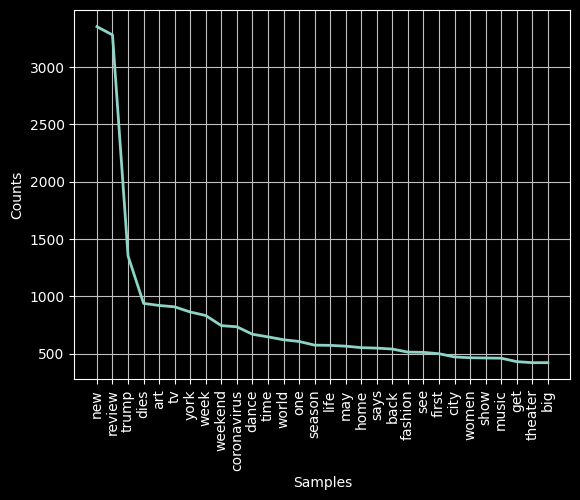

Sentiment: Sentiment(polarity=0.09144982652778705, subjectivity=0.412674463684342)


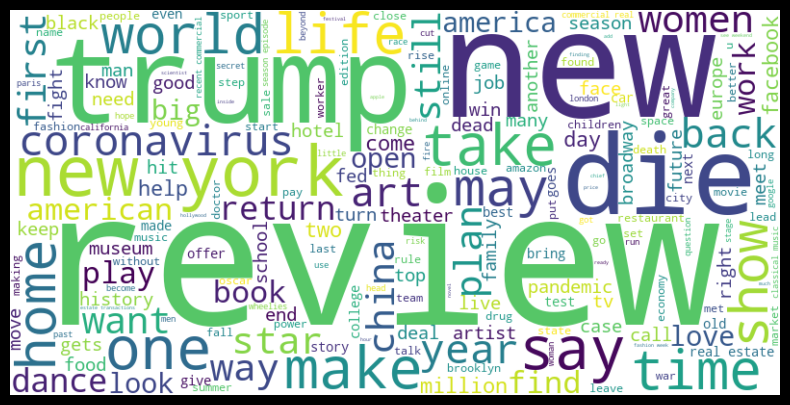

In [17]:
# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Assuming 'df' is your DataFrame
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]

    # Lemmatization (optional)
    # You may need to download the WordNet dataset for lemmatization
    # nltk.download('wordnet')
    # lemmatizer = nltk.WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

# Apply text preprocessing to the 'headline' column
df['processed_headline'] = df['headline'].apply(preprocess_text)

# Apply text preprocessing to the 'short_description' column
df['processed_short_description'] = df['abstract'].apply(preprocess_text)

# Word Frequency Analysis
def word_frequency_analysis(text):
    # Your word frequency analysis code here
    # Example: Calculate and plot word frequencies
    word_frequencies = nltk.FreqDist(word_tokenize(text))
    word_frequencies.plot(30, cumulative=False)

# Sentiment Analysis
def sentiment_analysis(text):
    # Your sentiment analysis code here
    # Example: Use a sentiment analysis library like TextBlob or Vader
    sentiment = TextBlob(text).sentiment
    print(f'Sentiment: {sentiment}')

# Word Cloud Visualization
def generate_word_cloud(text):
    # Your word cloud generation code here
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Example of how to use the processed text for word frequency analysis
# Replace 'processed_headline' with 'processed_short_description' if needed
word_frequency_analysis(df['processed_headline'].str.cat(sep=' '))

# Example of how to use the processed text for sentiment analysis
# Replace 'processed_headline' with 'processed_short_description' if needed
sentiment_analysis(df['processed_headline'].str.cat(sep=' '))

# Example of how to generate a word cloud
# Replace 'processed_headline' with 'processed_short_description' if needed
generate_word_cloud(df['processed_headline'].str.cat(sep=' '))

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_headline'], df['section'], test_size=0.2, random_state=42)

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Build a Naive Bayes classifier
classifier = MultinomialNB()

# Train the classifier
classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report and confusion matrix
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Fine-tune the model with GridSearchCV
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0]}
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'\nBest Parameters: {best_params}')

# Re-train the model with the best parameters
best_classifier = MultinomialNB(alpha=best_params['alpha'])
best_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set with the tuned model
y_pred_tuned = best_classifier.predict(X_test_tfidf)

# Evaluate the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f'\nTuned Model Accuracy: {accuracy_tuned:.2f}')

# Classification report and confusion matrix for the tuned model
print('\nTuned Model Classification Report:')
print(classification_report(y_test, y_pred_tuned))

print('\nTuned Model Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_tuned))

Accuracy: 0.55

Classification Report:
                 precision    recall  f1-score   support

   Art & Design       0.63      0.65      0.64       489
    Automobiles       0.87      0.52      0.65       266
          Books       0.45      0.54      0.49       476
          Dance       0.68      0.69      0.69       499
        Economy       0.69      0.54      0.61       286
      Education       0.77      0.15      0.25       132
Fashion & Style       0.46      0.44      0.45       465
           Food       0.56      0.60      0.58       450
Global Business       0.87      0.46      0.61       192
         Health       0.49      0.73      0.59       458
          Media       0.55      0.63      0.59       456
         Movies       0.48      0.56      0.52       469
          Music       0.69      0.66      0.67       516
        Opinion       0.38      0.49      0.43       478
    Real Estate       0.55      0.59      0.57       493
        Science       0.55      0.55      0.55  

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_headline'], df['section'], test_size=0.2, random_state=42)

# Tokenize and pad the sequences
max_words = 5000  # Adjust as needed
max_len = 100  # Adjust as needed
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Build the neural network model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(LSTM(512, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history= model.fit(X_train_pad, y_train_encoded, epochs=5, batch_size=128, validation_split=0.2)

# Evaluate the model
accuracy = model.evaluate(X_test_pad, y_test_encoded)[1]
print(f'Accuracy: {accuracy:.2f}')

Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.1487 - loss: 2.8413 - val_accuracy: 0.5070 - val_loss: 1.7819
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.5556 - loss: 1.5521 - val_accuracy: 0.5616 - val_loss: 1.5546
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.6622 - loss: 1.1736 - val_accuracy: 0.5694 - val_loss: 1.5662
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - accuracy: 0.7115 - loss: 0.9863 - val_accuracy: 0.5651 - val_loss: 1.6497
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.7450 - loss: 0.8667 - val_accuracy: 0.5605 - val_loss: 1.7414
307/307 ━━━━━━━━━━━━━━━━━━━━ 55s 179ms/step - accuracy: 0.5618 - loss: 1.7104
Accuracy: 0.56


In [41]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

307/307 ━━━━━━━━━━━━━━━━━━━━ 55s 178ms/step - accuracy: 0.5618 - loss: 1.7104
Test Accuracy: 55.78%


In [70]:
X_train_pad

array([[   0,    0,    0, ..., 2645,   76,  780],
       [   0,    0,    0, ...,  166,  564,  120],
       [   0,    0,    0, ..., 1199,   65,  963],
       ...,
       [   0,    0,    0, ..., 2049,  596, 1979],
       [   0,    0,    0, ...,  178,  208, 1307],
       [   0,    0,    0, ...,    2, 1862,   65]])

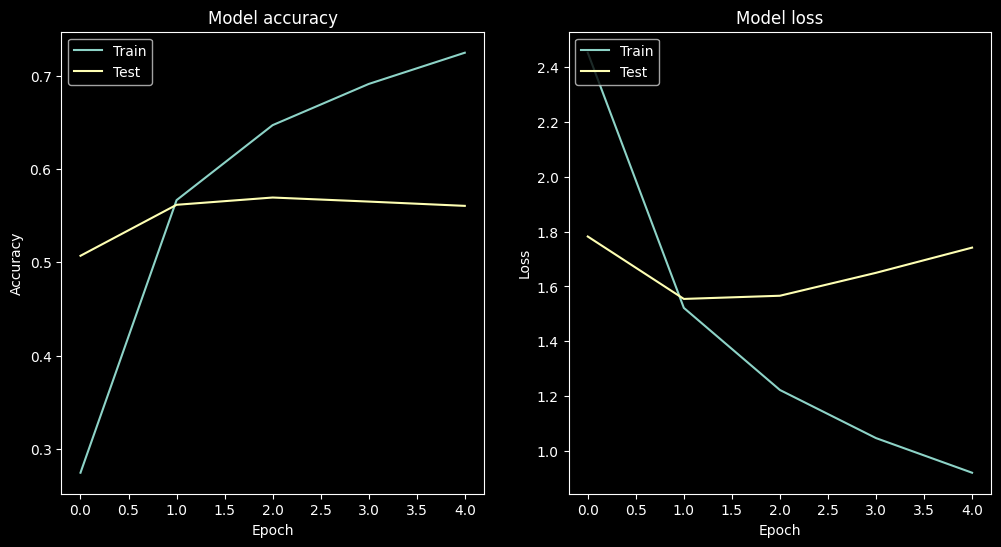

In [42]:
# Visualize training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [43]:
df['processed_headline']

0                walking dead friendship born classroom
1                             tv wednesday camp phoenix
2                    rays stick plan reach world series
3                     robert rauschenberg artist island
4           jimmy buffett musical sets broadway opening
                              ...                      
48983        recent commercial real estate transactions
48984    volvo recalls cars oil pressure sensor problem
48985                             family sedan speedway
48986                  lessons news media ground shifts
48987                      new york galleries see right
Name: processed_headline, Length: 48988, dtype: object

In [58]:
# Tokenize and pad the sequences
max_words = 5000  # Adjust as needed
max_len = 100  # Adjust as needed
tokenizer = Tokenizer(num_words=max_words)
input_string = 'jimmy buffett musical sets broadway opening'
tokenizer.fit_on_texts(input_string)
input_seq = tokenizer.texts_to_sequences(input_string)

input_pad = pad_sequences(input_seq, maxlen=max_len)
input_pad

array([[ 0,  0,  0, ...,  0,  0, 13],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  2],
       ...,
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0, 12],
       [ 0,  0,  0, ...,  0,  0, 20]])

In [59]:
res = model.predict(input_token)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [60]:
res[0]

array([4.05347999e-03, 2.52151536e-03, 8.79580900e-03, 2.31639598e-03,
       7.07000121e-03, 2.33178120e-03, 1.18097719e-02, 2.33394038e-02,
       4.68790968e-04, 1.15042835e-01, 4.40712459e-03, 2.34330539e-03,
       7.73786101e-04, 6.53745413e-01, 1.91648491e-02, 1.10930530e-02,
       2.56932769e-02, 5.21053523e-02, 1.45271234e-02, 1.12861441e-02,
       4.31333063e-03, 5.18140011e-03, 1.50960749e-02, 2.51997076e-03],
      dtype=float32)